In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(color_codes=True)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
import os
os.chdir("D:/instacart-recommender-bi")

In [3]:
usecols_orders = ["order_id", "user_id", "order_number", "order_dow",
                  "order_hour_of_day", "days_since_prior_order"]

orders = pd.read_csv("data/orders.csv", usecols=usecols_orders)

usecols_prior = ["order_id", "product_id", "add_to_cart_order", "reordered"]
order_products_prior = pd.read_csv("data/order_products__prior.csv", usecols=usecols_prior)

usecols_train = ["order_id", "product_id", "add_to_cart_order", "reordered"]
order_products_train = pd.read_csv("data/order_products__train.csv", usecols=usecols_train)

products = pd.read_csv("data/products.csv")
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")

In [4]:
print("orders:", orders.shape)
print("order_products_prior:", order_products_prior.shape)
print("order_products_train:", order_products_train.shape)
print("products:", products.shape)
print("aisles:", aisles.shape)
print("departments:", departments.shape)

orders: (3421083, 6)
order_products_prior: (32434489, 4)
order_products_train: (1384617, 4)
products: (49688, 4)
aisles: (134, 2)
departments: (21, 2)


In [5]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
orders.info()
orders.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
dtypes: float64(1), int64(5)
memory usage: 156.6 MB


order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [12]:
order_products_prior.info()
order_products_prior.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [13]:
order_products_train.info()
order_products_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [14]:
products.info()
products.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [15]:
orders["order_id"] = orders["order_id"].astype("int32")
orders["user_id"] = orders["user_id"].astype("int32")

order_products_prior["order_id"] = order_products_prior["order_id"].astype("int32")
order_products_prior["product_id"] = order_products_prior["product_id"].astype("int32")

order_products_train["order_id"] = order_products_train["order_id"].astype("int32")
order_products_train["product_id"] = order_products_train["product_id"].astype("int32")

products["product_id"] = products["product_id"].astype("int32")

In [16]:
product_lookup = products.merge(aisles, on="aisle_id").merge(departments, on="department_id")

In [17]:
product_counts = (
    order_products_prior["product_id"]
    .value_counts()
    .head(20)
    .to_frame("order_count")
    .reset_index()
    .rename(columns={"index": "product_id"})
)

top_products = product_counts.merge(product_lookup, on="product_id", how="left")

In [18]:
user_reorders = (
    order_products_prior.groupby("order_id")["reordered"].mean().reset_index()
)

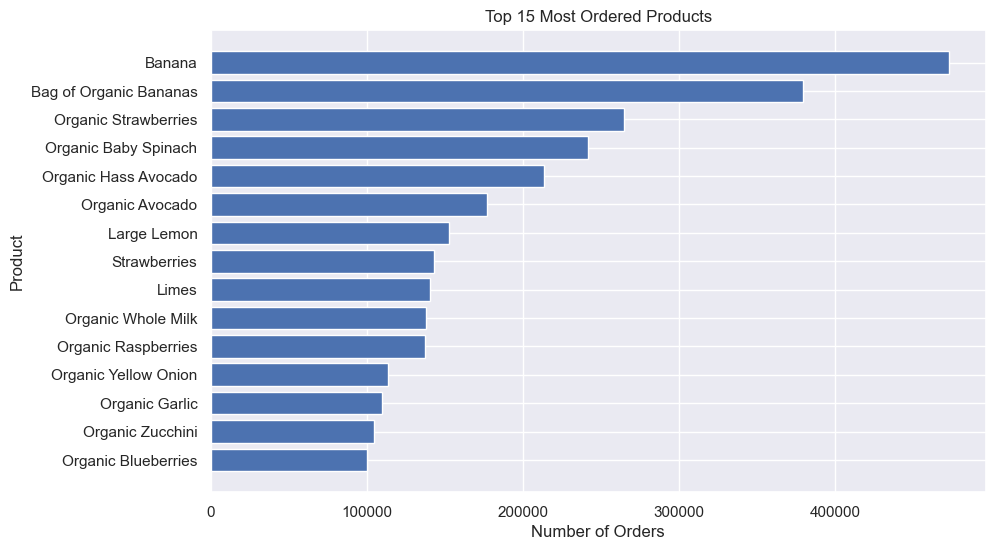

In [19]:
plt.figure(figsize=(10, 6))
plt.barh(top_products['product_name'].head(15), top_products['order_count'].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Most Ordered Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product")
plt.show()

In [20]:
aisle_counts = (
    order_products_prior
    .merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
    .groupby('aisle_id')
    .size()
    .reset_index(name='order_count')
    .merge(aisles, on='aisle_id', how='left')
    .sort_values('order_count', ascending=False)
    .head(15)
)

aisle_counts

,aisle_id,order_count,aisle
23,24,3642188,fresh fruits
82,83,3418021,fresh vegetables
122,123,1765313,packaged vegetables fruits
119,120,1452343,yogurt
20,21,979763,packaged cheese
83,84,891015,milk
114,115,841533,water seltzer sparkling water
106,107,722470,chips pretzels
90,91,638253,soy lactosefree
111,112,584834,bread


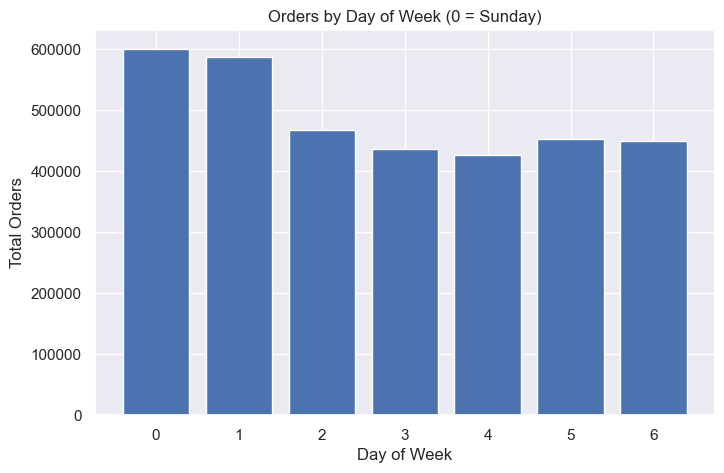

In [21]:
dow = orders['order_dow'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(range(7), dow)
plt.title("Orders by Day of Week (0 = Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Total Orders")
plt.show()

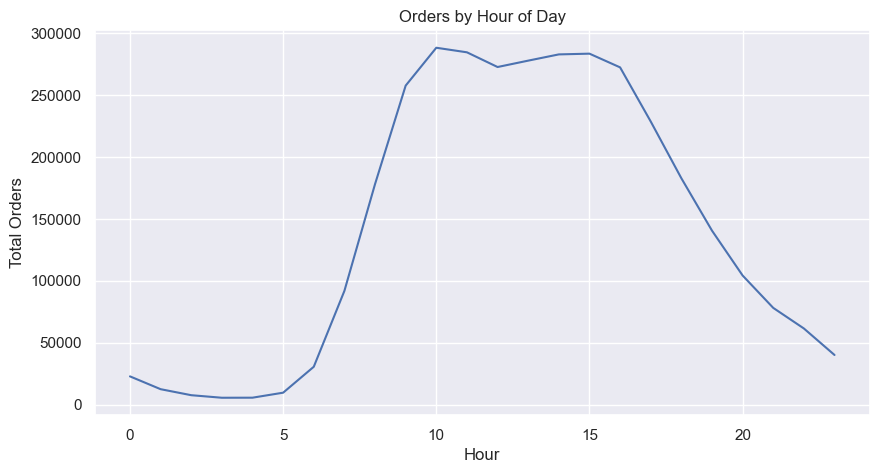

In [22]:
hour = orders['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(hour.index, hour.values)
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Total Orders")
plt.grid(True)
plt.show()

In [23]:
reorder_rate = order_products_prior['reordered'].mean()
reorder_rate

0.5896974667922161

In [24]:
reorder_by_product = (
    order_products_prior.groupby('product_id')['reordered'].mean()
    .reset_index()
    .merge(products[['product_id', 'product_name']], on='product_id')
    .sort_values('reordered', ascending=False)
    .head(15)
)

reorder_by_product


,product_id,reordered,product_name
6430,6433,0.941176,Raw Veggie Wrappers
2074,2075,0.931034,Serenity Ultimate Extrema Overnight Pads
43545,43553,0.923077,Orange Energy Shots
27734,27740,0.920792,Chocolate Love Bar
14605,14609,0.914286,Soy Powder Infant Formula
13871,13875,0.911111,Simply Sleep Nighttime Sleep Aid
39984,39992,0.909091,"Energy Shot, Grape Flavor"
5865,5868,0.900000,Russian River Valley Reserve Pinot Noir
31412,31418,0.900000,Sparking Water
35598,35604,0.900000,Maca Buttercups


In [25]:
orders_per_user = orders.groupby("user_id")["order_id"].count().reset_index(name="orders_count")
avg_days_per_user = orders.groupby("user_id")["days_since_prior_order"].mean().reset_index(name="avg_days_bw_orders")

In [26]:
user_reorder_rate = (
    order_products_prior.groupby("order_id")["reordered"].mean()
    .reset_index()
    .merge(orders[["order_id", "user_id"]], on="order_id")
    .groupby("user_id")["reordered"]
    .mean()
    .reset_index(name="user_reorder_rate")
)


In [27]:
user_profile = (
    orders_per_user
    .merge(avg_days_per_user, on="user_id")
    .merge(user_reorder_rate, on="user_id")
)


In [28]:
user_profile.head()
user_profile.shape

(206209, 4)

In [29]:
import itertools
from collections import Counter

pair_counter = Counter()

# Process in chunks to avoid memory overload
for order_id, group in order_products_prior.groupby("order_id"):
    products_in_order = group["product_id"].tolist()
    # generate product pairs
    for combo in itertools.combinations(products_in_order, 2):
        pair_counter[tuple(sorted(combo))] += 1

In [30]:
pair_df = pd.DataFrame(
    [(p1, p2, count) for (p1, p2), count in pair_counter.items()],
    columns=["product_1", "product_2", "count"]
)

In [31]:
top_pairs = pair_df.sort_values("count", ascending=False).head(20)
top_pairs

,product_1,product_2,count
162,13176,47209,62341
13170,13176,21137,61628
581,21137,24852,56156
578,24852,47766,53395
1647,21903,24852,51395
11582,13176,21903,50372
10260,16797,24852,41232
2675,24852,47626,40880
3074,21137,47209,40794
144,13176,27966,40503


In [34]:
scaler = StandardScaler()
scaled = scaler.fit_transform(user_profile[["orders_count", "avg_days_bw_orders", "user_reorder_rate"]])
kmeans = KMeans(n_clusters=4, random_state=42)
user_profile["segment"] = kmeans.fit_predict(scaled)
user_profile.groupby("segment").mean()

,user_id,orders_count,avg_days_bw_orders,user_reorder_rate
segment,,,,
0,102868.043939,18.723019,12.840784,0.615821
1,103158.823206,8.698420,12.534661,0.283038
2,102922.177797,56.080111,6.405276,0.735344
3,103386.147782,6.841762,23.603872,0.321139


In [35]:
aisle_order = (
    order_products_prior
    .merge(products[["product_id", "aisle_id"]], on="product_id")
    .merge(aisles, on="aisle_id")
)

In [36]:
basket_size = order_products_prior.groupby("order_id")["product_id"].count()
basket_size.describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

In [37]:
top200 = order_products_prior["product_id"].value_counts().head(200).index

In [38]:
filtered = order_products_prior[order_products_prior["product_id"].isin(top200)]

In [39]:
import itertools
from collections import Counter

pair_counter = Counter()

for order_id, group in filtered.groupby("order_id"):
    items = group["product_id"].tolist()
    for a, b in itertools.combinations(items, 2):
        pair_counter[tuple(sorted([a, b]))] += 1

In [40]:
pairs = pd.DataFrame(
    [(p1, p2, count) for (p1, p2), count in pair_counter.items()],
    columns=["product_1", "product_2", "score"]
).sort_values("score", ascending=False)


In [41]:
def recommend(product_id, top_n=5):
    results = pairs[pairs["product_1"] == product_id].sort_values("score", ascending=False)
    return results.head(top_n)


In [42]:
recommend(24852)

,product_1,product_2,score
35,24852,47766,53395
225,24852,47626,40880
358,24852,28204,33943
218,24852,49683,32097
1457,24852,26209,31772


In [51]:
train = order_products_train.merge(
    orders[["order_id", "user_id", "order_number"]],
    on="order_id"
)
train["user_total_orders"] = train["user_id"].map(
    orders.groupby("user_id")["order_id"].count()
)
train["product_popularity"] = train["product_id"].map(
    order_products_prior["product_id"].value_counts()
)

In [52]:
features = ["product_popularity", "user_total_orders", "order_number"]
X = train[features]
y = train["reordered"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [58]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.6360228799237336

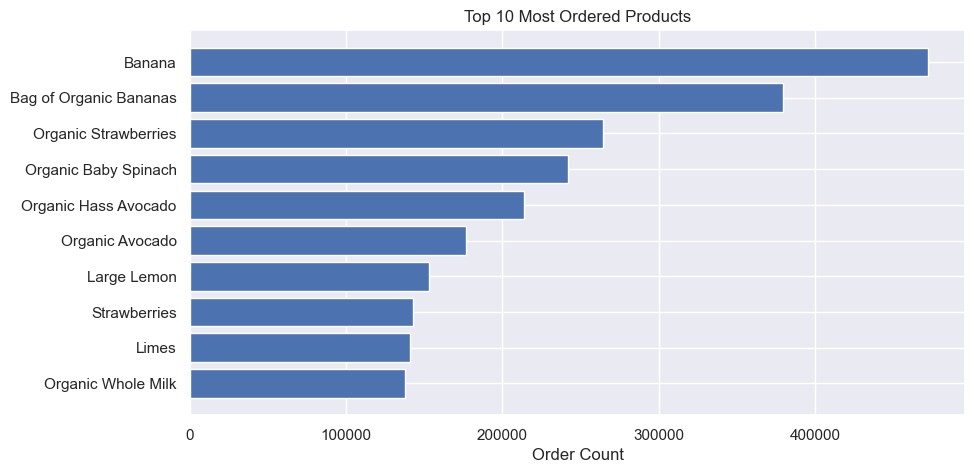

In [59]:
plt.figure(figsize=(10,5))
plt.barh(top_products['product_name'].head(10), top_products['order_count'].head(10))
plt.xlabel("Order Count")
plt.title("Top 10 Most Ordered Products")
plt.gca().invert_yaxis()
plt.show()


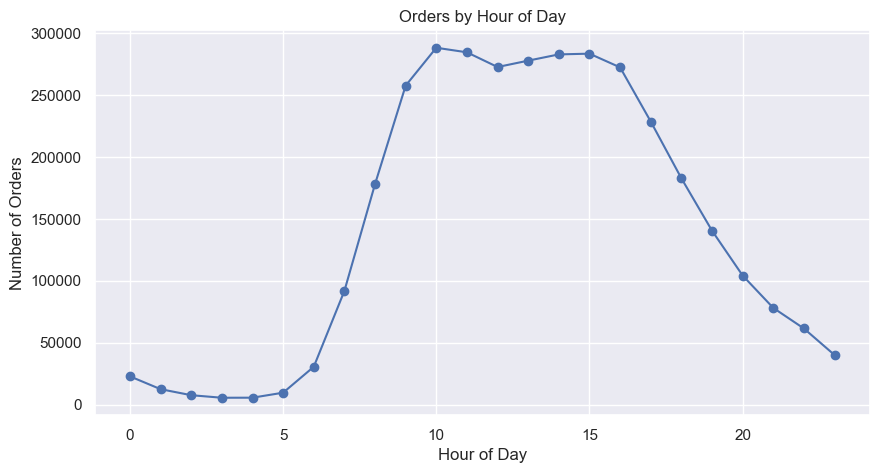

In [60]:
hour = orders['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(hour.index, hour.values, marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Orders by Hour of Day")
plt.grid(True)
plt.show()


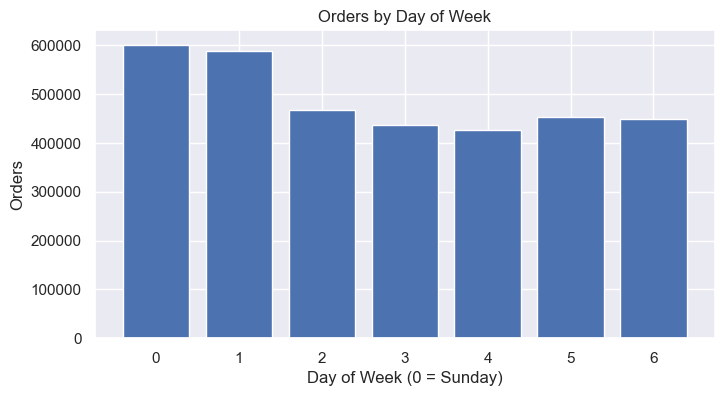

In [61]:
dow = orders['order_dow'].value_counts().sort_index()

plt.figure(figsize=(8,4))
plt.bar(dow.index, dow.values)
plt.xlabel("Day of Week (0 = Sunday)")
plt.ylabel("Orders")
plt.title("Orders by Day of Week")
plt.show()


In [62]:
reorder_rate = order_products_prior['reordered'].mean()
reorder_rate


0.5896974667922161

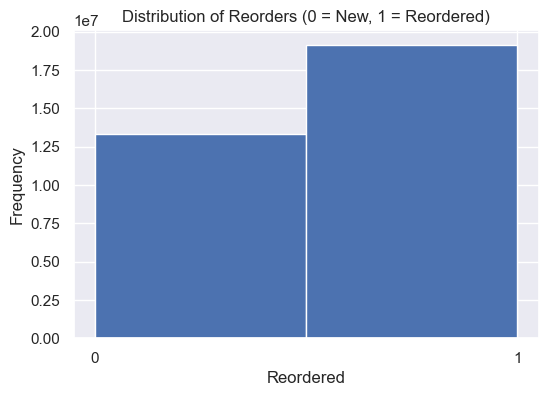

In [63]:
plt.figure(figsize=(6,4))
plt.hist(order_products_prior['reordered'], bins=2)
plt.xticks([0,1])
plt.xlabel("Reordered")
plt.ylabel("Frequency")
plt.title("Distribution of Reorders (0 = New, 1 = Reordered)")
plt.show()


In [65]:
plt.savefig("dashboards/top_products.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [66]:
top_products.to_csv("dashboards/top_products.csv", index=False)
orders.to_csv("dashboards/orders.csv", index=False)
aisle_counts.to_csv("dashboards/aisle_counts.csv", index=False)
user_reorder_rate.to_csv("dashboards/user_reorder_rate.csv", index=False)
pairs.head(50).to_csv("dashboards/product_pairs.csv", index=False)